In [1]:
import os
import datetime

OBSV_DATE = datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d")

# OBJ_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"
DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}
DATA_DIR = os.path.join(DATE_DATA_DIR, "qphot-results")
assert os.path.exists(DATA_DIR), f"{DATA_DIR} not found"
DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/qphot-results'

In [2]:
import pandas as pd
from astropy.io import ascii
from astropy.stats import sigma_clipped_stats
from astropy.timeseries import TimeSeries, BinnedTimeSeries
import astropy.units as u

OBSV_KEY = "OTIME"
# PHOTOMETRIC_BASE_KEYS = ["SUM", "FLUX", "MAG", "MERR"]
basePhotKey = "MAG"
baseErrPhotKey = "MERR"

data = ascii.read(os.path.join(DATA_DIR, "phot"))
pandasData = data.to_pandas()
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]

# For each star in STAR_IDS there will be a corresponding list of TimeSeries data, where each TimeSeries will correspond to an aperture
# Only doing this for one field at a time
starTimeSeries: dict[int, list[TimeSeries]] = {
	1: [],
	2: [],
	3: []
}

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		photKey = f"{basePhotKey}{apertureId}"
		errKey = f"{baseErrPhotKey}{apertureId}"
		apertureTimeSeries = BinnedTimeSeries(time_bin_start=starData[OBSV_KEY], time_bin_size=60.0 * u.second, 
			data={'mag': starData[photKey] * u.mag, 'err': starData[errKey] * u.mag, 'rapert': ([apertureRadius] * len(starData)) * u.pix})
		# TODO: try sigma clipping
		starTimeSeries[starId].append(apertureTimeSeries)

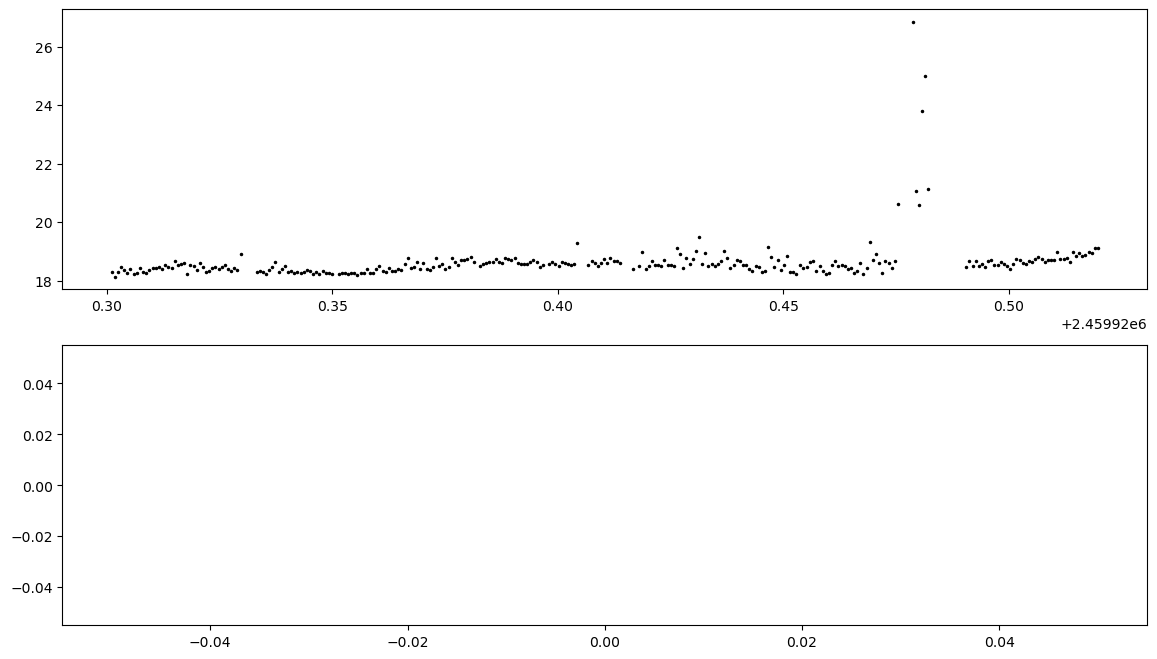

In [5]:
from astropy.timeseries import BoxLeastSquares

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (15,6)
# plt.style.use("science")

figure, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))

objTimeSeries = starTimeSeries[1][0]
axs[0].plot(objTimeSeries.time_bin_start.jd, objTimeSeries['mag'], 'k.', markersize=3)

model = BoxLeastSquares(t=objTimeSeries.time_bin_start, y=objTimeSeries['mag'], dy=objTimeSeries['err'])
periodogram = model.autopower(0.001)
axs[1].plot(periodogram.period, periodogram.power)

# objTimeSeries